<a href="https://colab.research.google.com/github/tekliyetamiru/Fine-Tuning-BERT-for-Multi-Class-Sentiment-Classification-for-Twitter-Tweets/blob/main/Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-Class Sentiment Recognition for Twitter Tweets using HuggingFace Transformers**

In [ ]:
!pip install -U transformers
!pip install -U accelerates
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

In [ ]:
!pip install -U pyarrow datasets pandas

## **Loading Data from Github**

In [ ]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/refs/heads/master/twitter_multi_class_sentiment.csv")
df

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


In [ ]:
df.isnull().sum()

,0
text,0
label,0
label_name,0


In [ ]:
df['label'].value_counts()

,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


In [ ]:
df.describe()

,label
count,16000.000000
mean,1.565937
std,1.501430
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


# Tokenization

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

text = "I love machine learning! Tokenization is awesome!!"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 3989, 2003, 12476, 999, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.3, stratify = df['label_name'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label_name'])
train.shape, test.shape, validation.shape

((11200, 3), (3200, 3), (1600, 3))

In [ ]:
from datasets import Dataset, DatasetDict

dataset=DatasetDict(
    {
    'train':Dataset.from_pandas(train,preserve_index=False),
    'test':Dataset.from_pandas(test,preserve_index=False),
    'validation':Dataset.from_pandas(validation,preserve_index=False)
    }
)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 1600
    })
})

In [ ]:
dataset['train'][0]

{'text': 'i feel unhappy it is no help for me that other persons say that i am happy how much truth there may be in it',
 'label': 0,
 'label_name': 'sadness'}

In [ ]:
def tokenize(batch):
  temp = tokenizer(batch['text'],padding=True, truncation=True)
  return temp

tokenize(dataset['train'][:2])

{'input_ids': [[101, 1045, 2514, 12511, 2009, 2003, 2053, 2393, 2005, 2033, 2008, 2060, 5381, 2360, 2008, 1045, 2572, 3407, 2129, 2172, 3606, 2045, 2089, 2022, 1999, 2009, 102], [101, 1045, 2001, 3110, 9191, 2043, 1045, 4149, 2009, 1998, 4415, 2043, 1045, 2001, 2725, 2026, 5789, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

In [ ]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [ ]:
label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'sadness': 0, 'joy': 1, 'fear': 4, 'surprise': 5, 'anger': 3, 'love': 2},
 {0: 'sadness', 1: 'joy', 4: 'fear', 5: 'surprise', 3: 'anger', 2: 'love'})

## **Model Building**

In [ ]:
from transformers import AutoModel
import torch

In [ ]:
model = AutoModel.from_pretrained(model_ckpt)

In [ ]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "dtype": "float32",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.57.6",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
from transformers import AutoModelForSequenceClassification,AutoConfig

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt,label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Building Training Arguments**

In [ ]:
from transformers import TrainingArguments

batch_size = 64
traing_dir = "bert_base_train_dir"

training_args = TrainingArguments(
    output_dir = traing_dir,
    overwrite_output_dir = True,
    num_train_epochs = 2,
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    eval_strategy = "epoch",
    disable_tqdm = False
)

### **Build compute metrics functions**

In [ ]:
!pip install evaluate

In [ ]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis = 1)
  return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds,average="weighted")
  acc = accuracy_score(labels,preds)

  return {"accuracy":acc, "f1":f1}

### **Building Model and Trainer**

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model,args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset = emotion_encoded["train"],
                  eval_dataset = emotion_encoded["validation"],
                  tokenizer = tokenizer)

/tmp/ipython-input-2237146537.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,args=training_args,


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.555927,0.805000,0.771032
2,No log,0.320678,0.910000,0.908362


TrainOutput(global_step=350, training_loss=0.7958018275669643, metrics={'train_runtime': 363.4465, 'train_samples_per_second': 61.632, 'train_steps_per_second': 0.963, 'total_flos': 1001502421516800.0, 'train_loss': 0.7958018275669643, 'epoch': 2.0})

### **Evaluate Model**

In [ ]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

{'test_loss': 0.3379438817501068,
 'test_accuracy': 0.895625,
 'test_f1': 0.8930844724131569,
 'test_runtime': 13.7834,
 'test_samples_per_second': 232.163,
 'test_steps_per_second': 3.628}

In [ ]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       933
           1       0.90      0.92      0.91      1072
           2       0.76      0.65      0.70       261
           3       0.91      0.89      0.90       432
           4       0.88      0.90      0.89       387
           5       0.86      0.61      0.71       115

    accuracy                           0.90      3200
   macro avg       0.87      0.82      0.84      3200
weighted avg       0.89      0.90      0.89      3200



### **Plot Confusion Matrix**

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

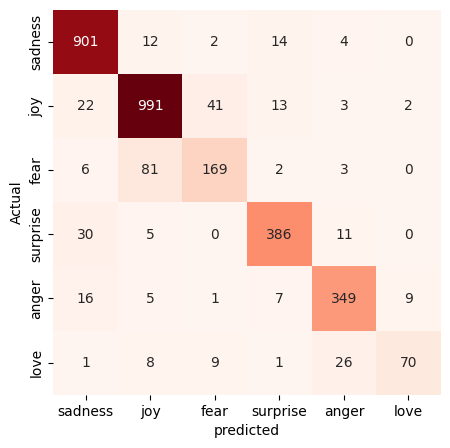

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True, xticklabels=label2id.keys(),yticklabels=label2id.keys(),fmt='d',cbar=False,cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("predicted")
plt.show()

### **Build Prediction Function and Store Model**

In [ ]:
text = "I am super happy today. I got it done. Finally!!"

def get_prediction(text):
  input_encoded = tokenizer(text,return_tensors='pt').to(device)

  with torch.no_grad():
    outputs = model(**input_encoded)

  logits = outputs.logits
  pred = torch.argmax(logits, dim=1).item()
  return id2label[pred]

In [ ]:
get_prediction(text)

'joy'

In [ ]:
trainer.save_model("bert-base-uncased-sentiment-model")

In [ ]:
# Use pipeline for prediction
from transformers import pipeline

classifier = pipeline("text-classification",model = 'bert-base-uncased-sentiment-model')

classifier([text,'hello, how are you?',"I love you","i am feeling low"])

Device set to use cuda:0


[{'label': 'joy', 'score': 0.9452272057533264},
 {'label': 'joy', 'score': 0.7332245707511902},
 {'label': 'joy', 'score': 0.4415004253387451},
 {'label': 'sadness', 'score': 0.9603583216667175}]

In [76]:
import nbformat

# Load your notebook file
file_path = '/content/drive/MyDrive/Colab Notebooks/Fine-tuning.ipynb' # Ensure this matches your filename
with open(file_path, 'r', encoding='utf-8') as f:
    nb = nbformat.read(f, as_version=4)

# Remove the problematic widgets metadata
if 'widgets' in nb.metadata:
    del nb.metadata['widgets']

# Save the cleaned notebook
with open(file_path, 'w', encoding='utf-8') as f:
    nbformat.write(nb, f)

print("Metadata cleaned! You can now push to GitHub.")

Metadata cleaned! You can now push to GitHub.
